In [2]:
#from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.SeqUtils import gc_fraction

import h5py
# for plotting
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# for analysis
import numpy as np
import os
import pandas as pd

# for modeling
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import spearmanr

from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, Ridge, RidgeCV, ElasticNet

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, cross_validate
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error, mean_absolute_error, precision_recall_curve, f1_score, auc, mean_squared_error,r2_score

import statsmodels.api as sm

import sys
import config_readwrite as crw

In [3]:
config, cfn = crw.read(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "config.ini"))

sei_config, sei_cfn = crw.read("/wynton/home/ahituv/fongsl/EMF/US/data/sei.config.ini")
section = "sei"

CHROM_PRED = sei_config[section]["chrom_pred"]
CLASS_PRED = sei_config[section]["class_pred"]
CLASS_TABLE = sei_config[section]["class_table"]
FASTA = sei_config[section]["fasta"]
FASTA_INDEX = sei_config[section]['fasta_index']
LABEL = sei_config[section]["LABELS"]
SEI_CHROM_LABELS = sei_config[section]["SEI_CHROM_LABELS"]

RE = config[section]["results"]

section= "data"
MPRA = config[section]["hepg2.clean.trans.scaled"]
TILEBED = config[section]["bed.atac.k27ac.tiles"]

# functions

In [4]:
def returnSequenceClassLabels():
    file = "/wynton/home/ahituv/fongsl/bin/sei-framework/sequence_class_labels.csv"
    lab = pd.read_csv(file)

    return lab

def processLabel(label_file, index_file):
    """
    input 
        label_file  (str) - path with the labels for the sequences run through the DNN

    Method
        1. opens sequence label file as pd dataframe
        2. if not none, read index file
        3. return label or label+index file
    """

    #1
    label = pd.read_csv(label_file, sep='\t', usecols = ["name"])
    label = label.rename(columns={"name":"seq_id"})
    print('label file', label.shape)

    # if index file exists, read index file
    if index_file is not None:
        index = pd.read_csv(index_file, sep='\t', header=None, names=["seq_id","name"])
        print("index file", index.shape)

        
        return pd.merge(label, index)
    else:
        return label
    

    
def makeClassPredTable(class_pred, labels, index_file, table_file):

    # get sequence class labels from function above
    seqClass = returnSequenceClassLabels()
    
    # open npy data
    data = np.load(class_pred, allow_pickle=True)

    # turn into pd dataframe
    df = pd.DataFrame(data)

    # rename columns
    df.columns = list(seqClass["#Sequence class label"])[:-1]

    # process labels file
    lab = processLabel(labels, index_file)

    # add labels and data together
    df = pd.merge(lab, df, left_index=True, right_index=True)

    # write table to table file. 
    df.to_csv(table_file, sep='\t', index=False, compression="gzip")
    
    return df

def returnSequenceClassLabels():
    file = "/wynton/home/ahituv/fongsl/bin/sei-framework/sequence_class_labels.csv"
    lab = pd.read_csv(file)

    return lab

def seqClassLookup(annot_list):
    print(seqClass.loc[seqClass[seqClass.columns[0]].isin(annot_list)])


def getColorMap(col, df, cmap):
    
    lut = dict(zip(df[col].unique(), cmap))
    print(lut)

    row_colors = df[col].map(lut)

    return row_colors, lut

def plotClusterMap(table, outhandle, seq_coor):
    sns.clustermap(table, cmap="bwr", center=0,
                       figsize=(15, 15))
        
    plt.savefig(os.path.join(RE, f"{outhandle}.{seq_coor}.pdf"))
    plt.show()

# sei

In [5]:
def readH5df(file):
    h5in=h5py.File(file, "r")
    hdf = pd.DataFrame(np.array(h5in["data"]))
    
    return hdf

def getQueryDf(chrom_df, col_indexes, col_names):
    
    query = chrom_df[col_indexes].copy()
    query.columns = col_names
    print(chrom_df.shape, query.shape)
    
    return query

## params - cell lines

In [6]:
QUERY = "HepG2"

## sei cell line predictions

In [7]:
query_indexes, query_names =[], []

with open(SEI_CHROM_LABELS, "r") as reader:
    for n, label in enumerate(reader):
        if QUERY in label:
            query_indexes.append(n), query_names.append(label.strip("\n"))
            print(n, label)

142 HepG2_Epithelium_Liver|CEBPA|ID:1374

143 HepG2_Epithelium_Liver|CEBPA|ID:1375

144 HepG2_Epithelium_Liver|CTCF|ID:1380

145 HepG2_Epithelium_Liver|CTCF|ID:1381

146 HepG2_Epithelium_Liver|CTCF|ID:1382

147 HepG2_Epithelium_Liver|CTCF|ID:1383

148 HepG2_Epithelium_Liver|HNF4A|ID:1447

149 HepG2_Epithelium_Liver|HNF4A|ID:1448

150 HepG2_Epithelium_Liver|HNF4A|ID:1449

151 HepG2_Epithelium_Liver|NR2C2|ID:1463

152 HepG2_Epithelium_Liver|NR2C2|ID:1464

153 HepG2_Epithelium_Liver|RAD21|ID:1470

154 HepG2_Epithelium_Liver|RAD21|ID:1471

155 HepG2_Epithelium_Liver|STAG1|ID:1492

156 HepG2_Epithelium_Liver|STAG1|ID:1493

984 HepG2_Epithelium_Liver|DNase|ID:33596

989 HepG2_Epithelium_Liver|FAIRE|ID:33602

990 HepG2_Epithelium_Liver|DNase|ID:33603

991 HepG2_Epithelium_Liver|FAIRE|ID:33605

995 HepG2_Epithelium_Liver|FAIRE|ID:33609

998 HepG2_Epithelium_Liver|DNase|ID:33612

1525 HepG2_Epithelium_Liver|H3K4me3|ID:35922

1526 HepG2_Epithelium_Liver|H3K4me3|ID:35923

1739 HepG2_Epithelium_Li

## chromatin predictions

In [8]:
chrom = readH5df(CHROM_PRED)

chrom.head()

,0,1,2,3,4,5,6,7,8,9,...,21897,21898,21899,21900,21901,21902,21903,21904,21905,21906
0,0.000173,0.000720,0.000009,0.000110,0.000018,0.000168,0.000090,1.912478e-07,0.000002,0.000001,...,0.000502,0.000033,0.000016,0.000148,0.000112,0.000006,0.000259,3.824396e-06,0.000572,0.000360
1,0.000060,0.006822,0.000069,0.001058,0.000072,0.000455,0.000615,3.261040e-06,0.000013,0.000007,...,0.000995,0.000034,0.000020,0.000144,0.000233,0.000002,0.001239,1.094838e-06,0.000902,0.000227
2,0.000162,0.014394,0.001789,0.003007,0.000859,0.001558,0.017721,1.177286e-05,0.000022,0.000050,...,0.001575,0.000115,0.001025,0.018507,0.014362,0.000014,0.006498,4.700571e-05,0.034633,0.088095
3,0.000051,0.004095,0.000085,0.000956,0.000095,0.000747,0.000740,3.687764e-06,0.000013,0.000006,...,0.000571,0.000039,0.000014,0.000187,0.000182,0.000003,0.001382,6.385764e-07,0.000601,0.000109
4,0.000117,0.003649,0.000297,0.001196,0.000253,0.002025,0.030870,2.039543e-06,0.000005,0.000027,...,0.000906,0.000101,0.000856,0.041069,0.029421,0.000008,0.002488,4.848729e-05,0.150051,0.316450


## get query df feature matrix subset

In [9]:
qdf = getQueryDf(chrom, query_indexes, query_names)

qdf.head()

(82427, 21907) (82427, 386)


,HepG2_Epithelium_Liver|CEBPA|ID:1374,HepG2_Epithelium_Liver|CEBPA|ID:1375,HepG2_Epithelium_Liver|CTCF|ID:1380,HepG2_Epithelium_Liver|CTCF|ID:1381,HepG2_Epithelium_Liver|CTCF|ID:1382,HepG2_Epithelium_Liver|CTCF|ID:1383,HepG2_Epithelium_Liver|HNF4A|ID:1447,HepG2_Epithelium_Liver|HNF4A|ID:1448,HepG2_Epithelium_Liver|HNF4A|ID:1449,HepG2_Epithelium_Liver|NR2C2|ID:1463,...,HepG2|TCF12|ENCODE,HepG2|TCF7L2|ENCODE,HepG2|TEAD4|ENCODE,HepG2|TR4|ENCODE,HepG2|USF-1|ENCODE,HepG2|USF2|ENCODE,HepG2|YY1|ENCODE,HepG2|ZBTB33|ENCODE,HepG2|ZBTB7A|ENCODE,HepG2|ZNF274|ENCODE
0,0.000005,0.000012,0.000154,0.000005,0.000004,0.000005,0.000006,0.000003,8.319064e-07,0.000002,...,7.216546e-07,0.000027,0.000024,0.000004,0.000108,0.000025,0.000002,0.000008,0.000004,0.000006
1,0.000014,0.000020,0.000077,0.000005,0.000009,0.000010,0.000020,0.000007,1.627981e-06,0.000005,...,2.254021e-06,0.000036,0.000025,0.000007,0.000035,0.000008,0.000004,0.000015,0.000012,0.000022
2,0.000042,0.000043,0.000993,0.000018,0.000055,0.000036,0.000131,0.000019,1.389099e-05,0.000007,...,1.103815e-05,0.000033,0.000480,0.000023,0.000078,0.000054,0.000011,0.000014,0.000024,0.000080
3,0.000014,0.000018,0.000098,0.000005,0.000011,0.000012,0.000014,0.000006,1.328542e-06,0.000003,...,1.525808e-06,0.000020,0.000010,0.000004,0.000034,0.000007,0.000003,0.000008,0.000008,0.000018
4,0.000070,0.000080,0.001686,0.000020,0.000030,0.000030,0.000225,0.000033,1.913480e-05,0.000008,...,2.830637e-05,0.000046,0.000673,0.000022,0.000363,0.000183,0.000009,0.000029,0.000021,0.000053


In [10]:
del chrom

In [11]:
# process labels file
lab = processLabel(LABEL, FASTA_INDEX)

# add seq_id, name labels to feature matrix
sei = pd.merge(lab, qdf, left_index=True, right_index=True)

sei.head()

label file (82427, 1)
index file (82427, 2)


,seq_id,name,HepG2_Epithelium_Liver|CEBPA|ID:1374,HepG2_Epithelium_Liver|CEBPA|ID:1375,HepG2_Epithelium_Liver|CTCF|ID:1380,HepG2_Epithelium_Liver|CTCF|ID:1381,HepG2_Epithelium_Liver|CTCF|ID:1382,HepG2_Epithelium_Liver|CTCF|ID:1383,HepG2_Epithelium_Liver|HNF4A|ID:1447,HepG2_Epithelium_Liver|HNF4A|ID:1448,...,HepG2|TCF12|ENCODE,HepG2|TCF7L2|ENCODE,HepG2|TEAD4|ENCODE,HepG2|TR4|ENCODE,HepG2|USF-1|ENCODE,HepG2|USF2|ENCODE,HepG2|YY1|ENCODE,HepG2|ZBTB33|ENCODE,HepG2|ZBTB7A|ENCODE,HepG2|ZNF274|ENCODE
0,seq.0,bj_k27ac_down_chr3:29837526-29837795,0.000005,0.000012,0.000154,0.000005,0.000004,0.000005,0.000006,0.000003,...,7.216546e-07,0.000027,0.000024,0.000004,0.000108,0.000025,0.000002,0.000008,0.000004,0.000006
1,seq.1,bj_k27ac_down_chr3:29837260-29837529,0.000014,0.000020,0.000077,0.000005,0.000009,0.000010,0.000020,0.000007,...,2.254021e-06,0.000036,0.000025,0.000007,0.000035,0.000008,0.000004,0.000015,0.000012,0.000022
2,seq.2,bj_k27ac_down_chr3:29837792-29838061,0.000042,0.000043,0.000993,0.000018,0.000055,0.000036,0.000131,0.000019,...,1.103815e-05,0.000033,0.000480,0.000023,0.000078,0.000054,0.000011,0.000014,0.000024,0.000080
3,seq.3,bj_k27ac_down_chr3:29837392-29837661,0.000014,0.000018,0.000098,0.000005,0.000011,0.000012,0.000014,0.000006,...,1.525808e-06,0.000020,0.000010,0.000004,0.000034,0.000007,0.000003,0.000008,0.000008,0.000018
4,seq.4,bj_k27ac_down_chr3:29837659-29837928,0.000070,0.000080,0.001686,0.000020,0.000030,0.000030,0.000225,0.000033,...,2.830637e-05,0.000046,0.000673,0.000022,0.000363,0.000183,0.000009,0.000029,0.000021,0.000053


## prediction distribution sei

In [12]:
sei_melt = pd.melt(sei, id_vars=["seq_id", "name"])

sei_melt["cl"] = sei_melt["variable"].apply(lambda x: x.split("|")[0])
sei_melt["marker"] = sei_melt["variable"].apply(lambda x: x.split("|")[1])
sei_melt["marker_id"] = sei_melt["variable"].apply(lambda x: x.split("|")[2])

sei_melt.head()

,seq_id,name,variable,value
0,seq.0,bj_k27ac_down_chr3:29837526-29837795,HepG2_Epithelium_Liver|CEBPA|ID:1374,0.000005
1,seq.1,bj_k27ac_down_chr3:29837260-29837529,HepG2_Epithelium_Liver|CEBPA|ID:1374,0.000014
2,seq.2,bj_k27ac_down_chr3:29837792-29838061,HepG2_Epithelium_Liver|CEBPA|ID:1374,0.000042
3,seq.3,bj_k27ac_down_chr3:29837392-29837661,HepG2_Epithelium_Liver|CEBPA|ID:1374,0.000014
4,seq.4,bj_k27ac_down_chr3:29837659-29837928,HepG2_Epithelium_Liver|CEBPA|ID:1374,0.000070


In [ ]:
# get marker order
chrom_means = sei_melt.groupby("marker")["value"].mean().reset_index()

ordered_markers = chrom_means.sort_values(by="value", ascending=False)["marker"]

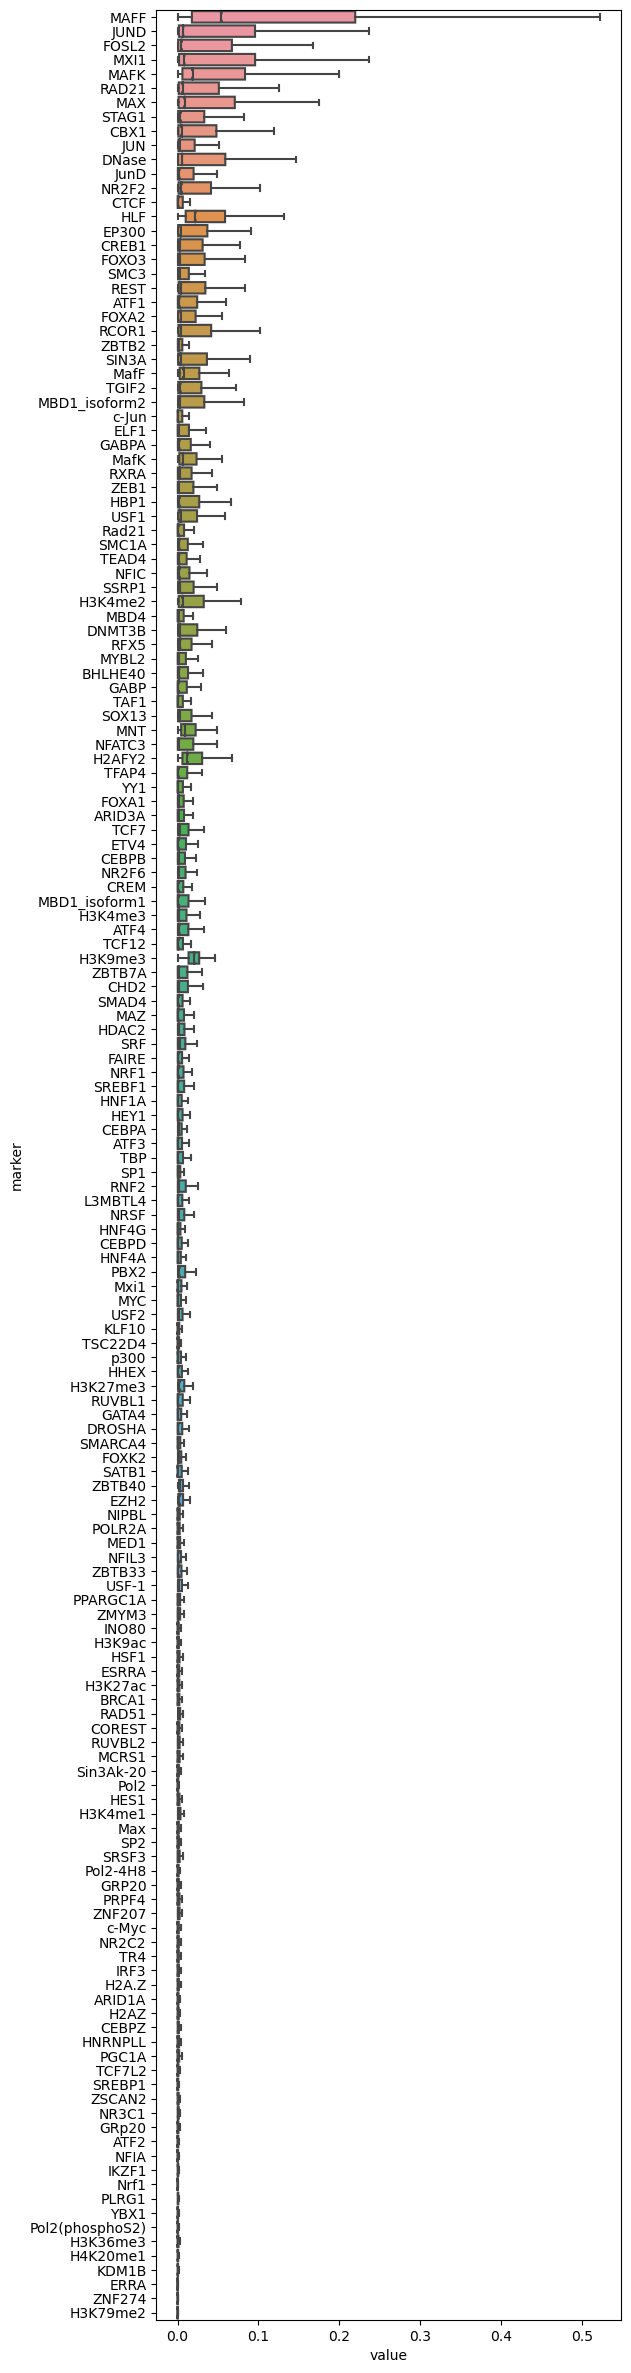

In [24]:
fig, ax = plt.subplots(figsize=(6,30))
y = "marker"
x = "value"
data=sei_melt
sns.boxplot(x=x,y=y,data=data, order=ordered_markers, showfliers =False, notch=True)
OUT = os.path.join(RE, f"reg.chromatin.sei.pdf")
plt.savefig(OUT,bbox_inches='tight')

# MPRA - scaled

In [25]:
mpra = pd.read_csv(MPRA, sep='\t')

mpra.head()

,name,l2.ratio.1.ctrl,l2.ratio.2.ctrl,l2.ratio.3.ctrl,l2.ratio.1.us,l2.ratio.2.us,l2.ratio.3.us,l2.ratio.med.ctrl,l2.ratio.mean.ctrl,l2.ratio.std.ctrl,l2.ratio.med.us,l2.ratio.mean.us,l2.ratio.std.us,delta.med,delta.mean,pval,label.ctrl,label.us,response
0,SYNTHETIC:_Added_CCTTCCTG_GCCCGGGGG_TATACATA_a...,-1.734932,-1.567864,-1.754317,-1.296335,-1.276191,-1.294565,-1.734932,-1.685704,0.102512,-1.294565,-1.289030,0.011155,0.440367,0.396674,0.020518,False,False,False
1,hob_k27ac_up_chr1:67427680-67427949,-0.424418,-0.573461,-0.482278,-0.718239,-0.742376,-0.715355,-0.482278,-0.493385,0.075140,-0.718239,-0.725323,0.014838,-0.235962,-0.231938,0.029332,False,False,False
2,SYNTHETIC:_The_motif_ATTAAA_was_added_in_Pos:8...,-0.536486,-0.727045,-0.652711,-0.063230,-0.100000,-0.030887,-0.652711,-0.638747,0.096044,-0.063230,-0.064706,0.034580,0.589482,0.574042,0.004667,False,False,False
3,SYNTHETIC:_Added_TATGACTCATA_ACAGGTGTAC_ACAGGT...,0.035693,-0.341065,-0.087809,-0.984858,-1.007522,-0.870307,-0.087809,-0.131060,0.192067,-0.984858,-0.954229,0.073557,-0.897049,-0.823169,0.009918,False,False,False
4,k562_atac_up_chr15:78056378-78056647,1.793414,1.153666,1.886389,1.402855,1.376605,1.427877,1.793414,1.611156,0.398917,1.402855,1.402446,0.025639,-0.390560,-0.208711,0.460596,True,True,False


In [32]:
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# tiles x enhancers

In [41]:
bed = pd.read_csv(TILEBED, sep='\t',)
bed.head()

print("shuffles",len(bed.loc[bed["shuf"]== True, "enh_id"].drop_duplicates()))
print("pos controls", len(bed.loc[bed["name"].str.contains("Pos"), "enh_id"].drop_duplicates()))

shuffles 204
pos controls 2


In [42]:
print("n atac/k27ac in sei:", len(set(bed["name"]).intersection(set(sei["name"]))))  # 24047 MPRA sequences missing sei data
print("n sei not in atac (synthetics):", len(set(sei["name"]).difference(set(bed["name"]))))  # 38480 sei sequences missing MPRA data

n atac/k27ac in sei: 42308
n sei not in atac (synthetics): 40119


In [43]:
sei.shape, mpra.shape, bed.shape

((82427, 388), (67994, 19), (43989, 10))

# merged sei + MPRA

In [44]:
merged = pd.merge(mpra[["name", 'delta.med', 'delta.mean', 'l2.ratio.mean.ctrl','l2.ratio.mean.us']], sei)
print(merged.shape)
merged = pd.merge(merged, bed[['name', "enh_id", "#chr"]].drop_duplicates())
print(merged.shape)
print("n tiles w/ endogenous enhancer id, MPRA activity and sei predictions",
      merged.shape[0])
print("n enhancer_ids w/ MPRA activity", len(merged["enh_id"].unique()))

(43947, 392)
(32850, 394)
n tiles w/ endogenous enhancer id, MPRA activity and sei predictions 32850
n enhancer_ids w/ MPRA activity 9826


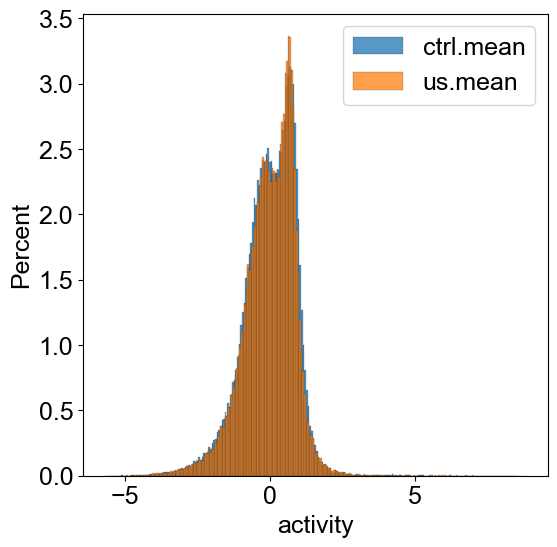

In [45]:
fig, ax = plt.subplots(figsize=(6,6))
sns.histplot(x="l2.ratio.mean.ctrl", data=mpra, stat="percent",label="ctrl.mean")
sns.histplot(x="l2.ratio.mean.us", data=mpra,stat="percent", label = "us.mean")
#sns.histplot(x="delta.mean", data=mpra,stat="percent", label = "delta.mean")
ax.set(xlabel="activity")
ax.legend()

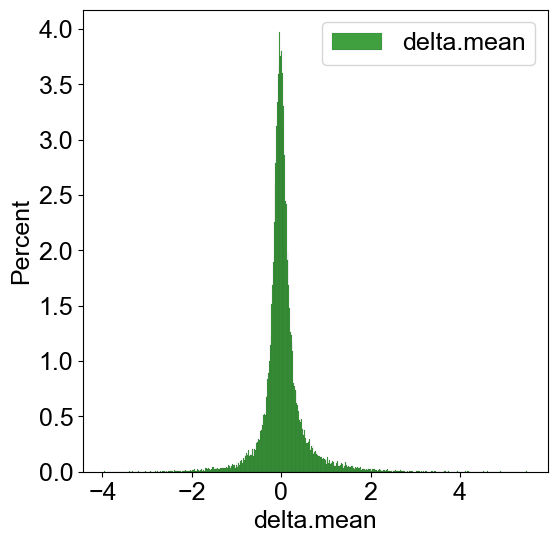

In [46]:
fig, ax = plt.subplots(figsize=(6,6))
sns.histplot(x="delta.mean", data=merged,stat="percent", label = "delta.mean", color="g")
#ax.set(xlabel="activity")
ax.legend()

# X and Y
x = sei predictions
y = delta activity

In [48]:
# params

y_cols=[ "l2.ratio.mean.ctrl", "l2.ratio.mean.us", "delta.med", "delta.mean",]
group_col = "#chr"
train_size = 0.8
data = merged
feature_matrix = merged
sei_cols = list(feature_matrix)[6:-2]

## train test split 

In [49]:
def train_test_split_Group(X, y, groups, train_size):
    """ group split for train, test
    inputs
        X - np array of features
        y - np array of predictor
        groups - np array of group labels
        train_size - float, fraction of training
    """
    gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=42)
    for train_index, test_index in gss.split(X, y, groups):
        trainx, testx = X[train_index], X[test_index]

        trainy, testy = y[train_index], y[test_index]
        
        print(f"  Train: index={train_index}, group={np.unique(groups[train_index])}")
        print(f"  Test:  index={test_index}, group={np.unique(groups[test_index])}")
        print(len(set(np.unique(groups[train_index])).intersection(set(np.unique(groups[test_index])))))

    return trainx, trainy, testx, testy, train_index, test_index

In [50]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('reg', LinearRegression())])

## pipeline

predicting l2.ratio.mean.ctrl
  Train: index=[    1     2     3 ... 32843 32845 32848], group=['chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr19' 'chr20'
 'chr22' 'chr22_KI270733v1_random' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7'
 'chr9' 'chrUn_GL000195v1' 'chrUn_GL000219v1' 'chrX' 'chrY']
  Test:  index=[    0     4    12 ... 32846 32847 32849], group=['chr1' 'chr17' 'chr18' 'chr2' 'chr21' 'chr8']
0
performance r2 0.07046189314549411 rho 0.2790745697280071
error rmse 0.8139046988701553 mae 0.6800880161415068
predicting l2.ratio.mean.us
  Train: index=[    1     2     3 ... 32843 32845 32848], group=['chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr19' 'chr20'
 'chr22' 'chr22_KI270733v1_random' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7'
 'chr9' 'chrUn_GL000195v1' 'chrUn_GL000219v1' 'chrX' 'chrY']
  Test:  index=[    0     4    12 ... 32846 32847 32849], group=['chr1' 'chr17' 'chr18' 'chr2' 'chr21' 'chr8']
0
performance r2 0.058143503665628815 rho 0.2525683338292168
error rmse

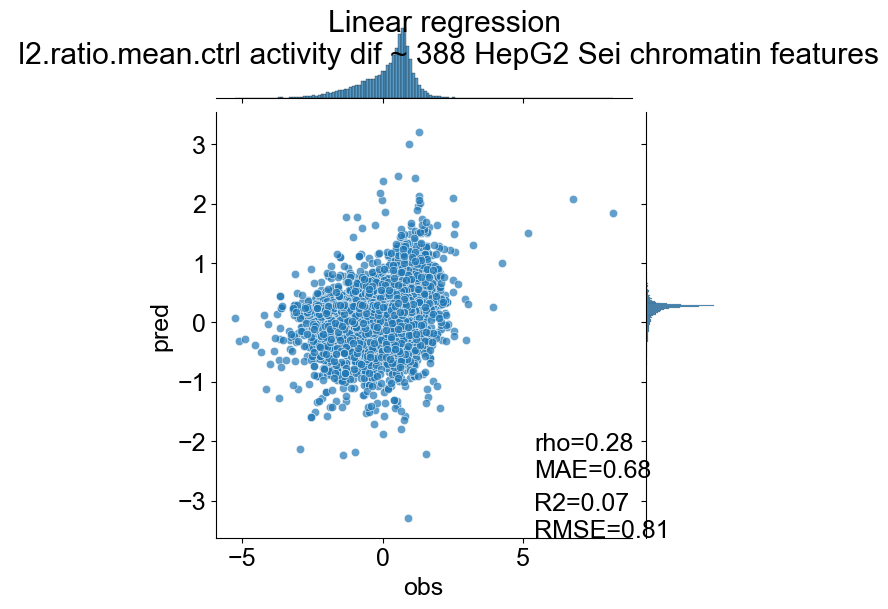

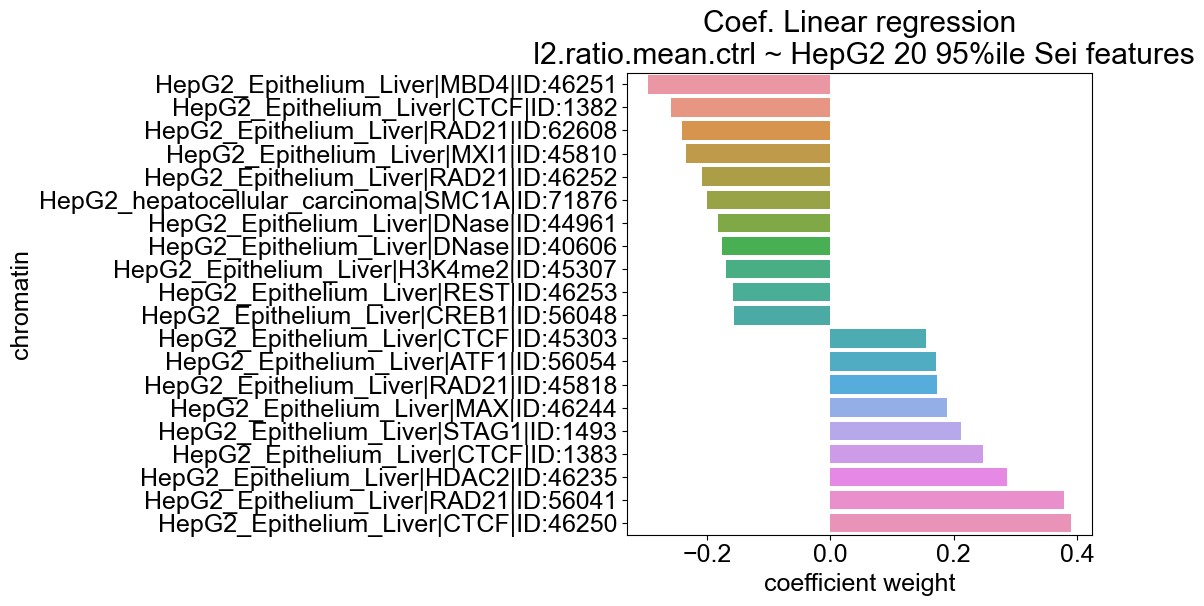

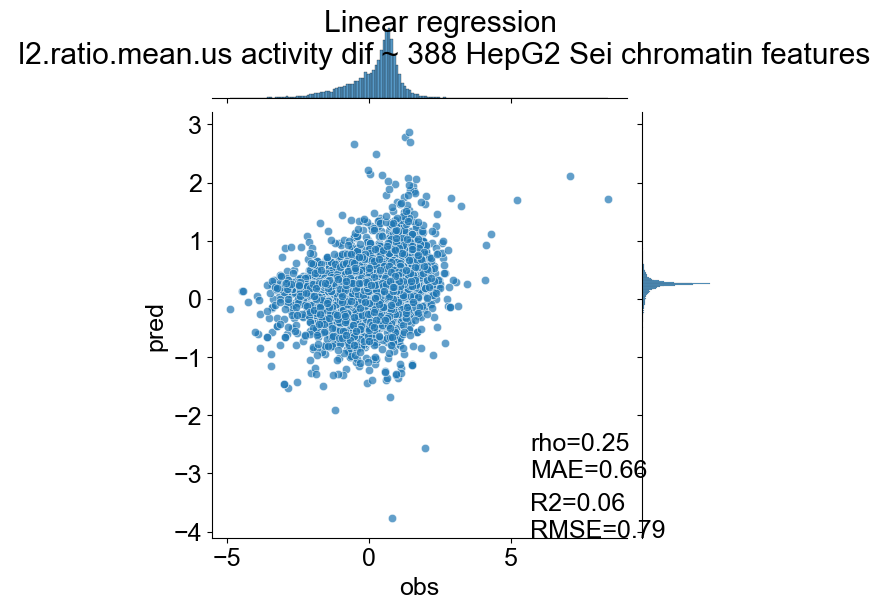

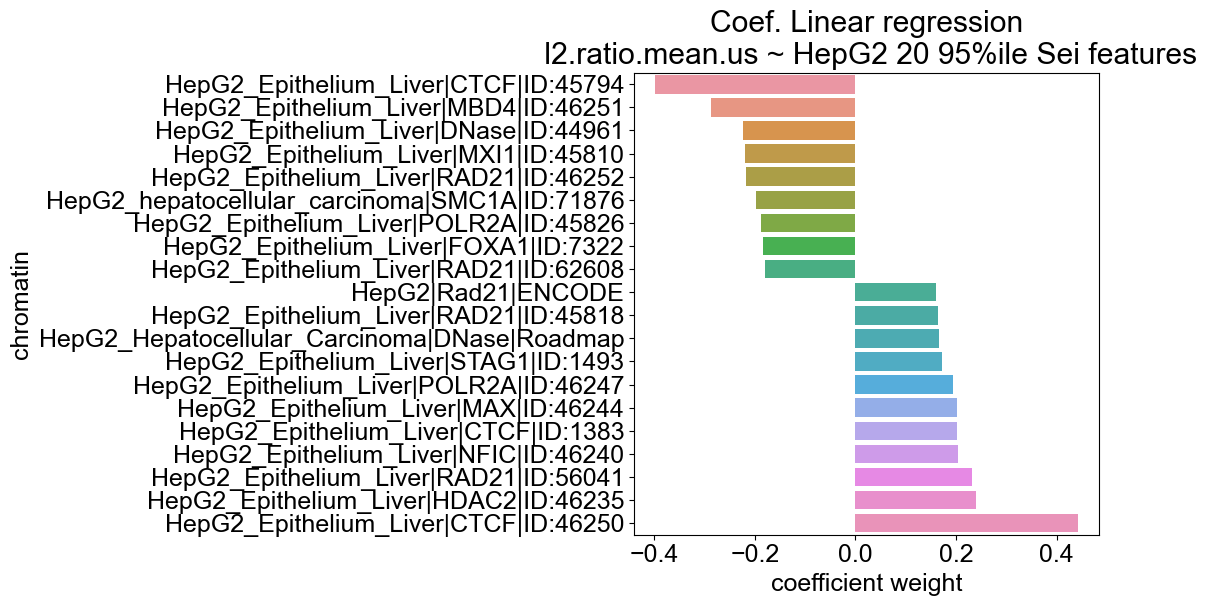

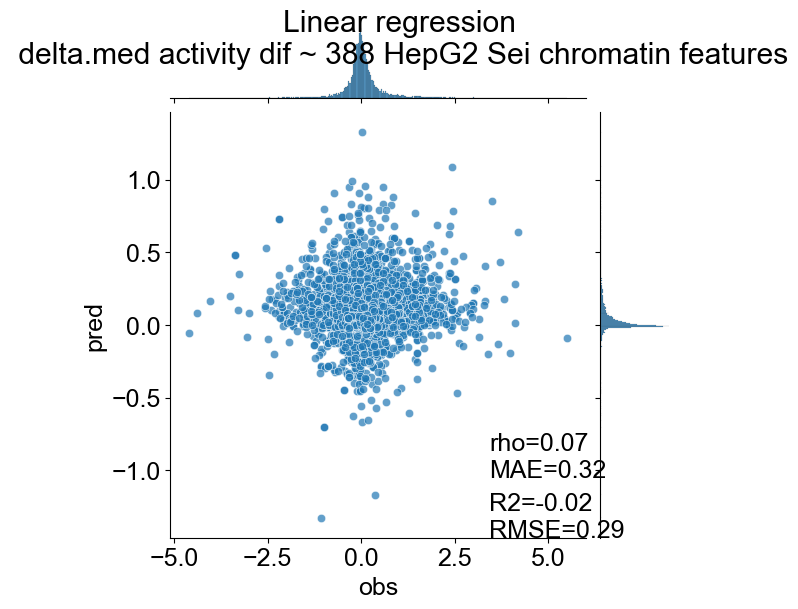

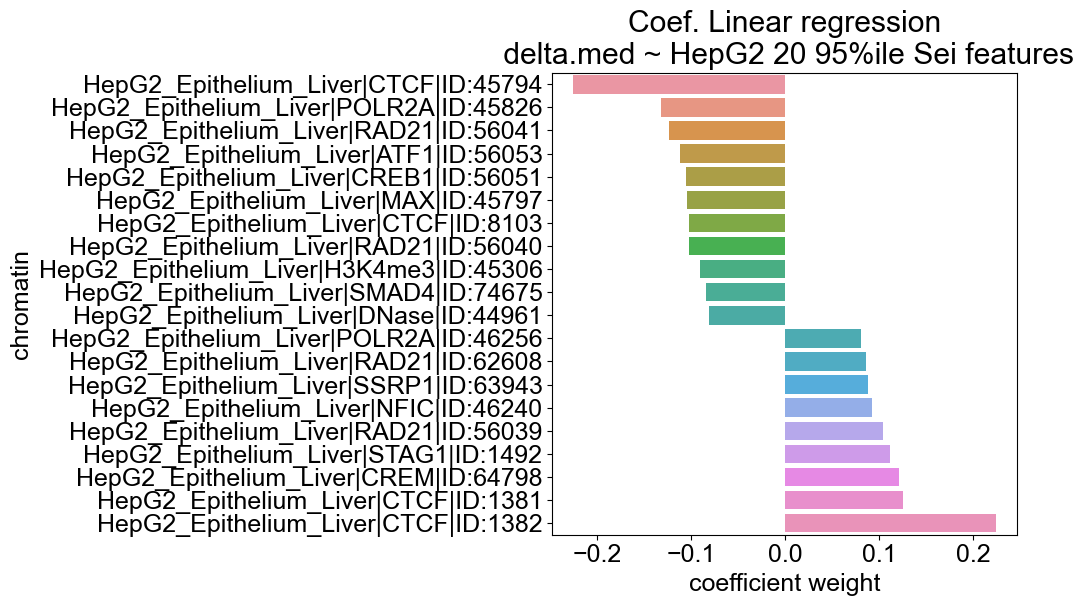

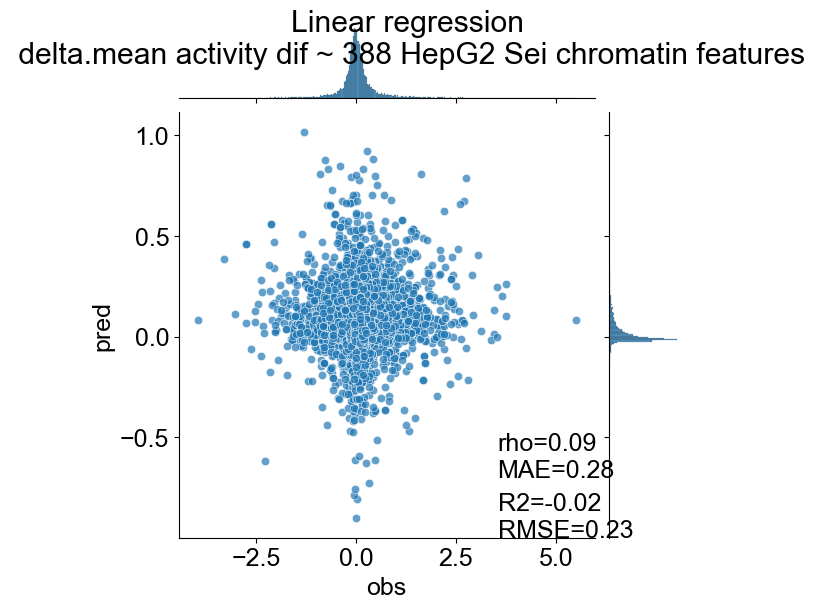

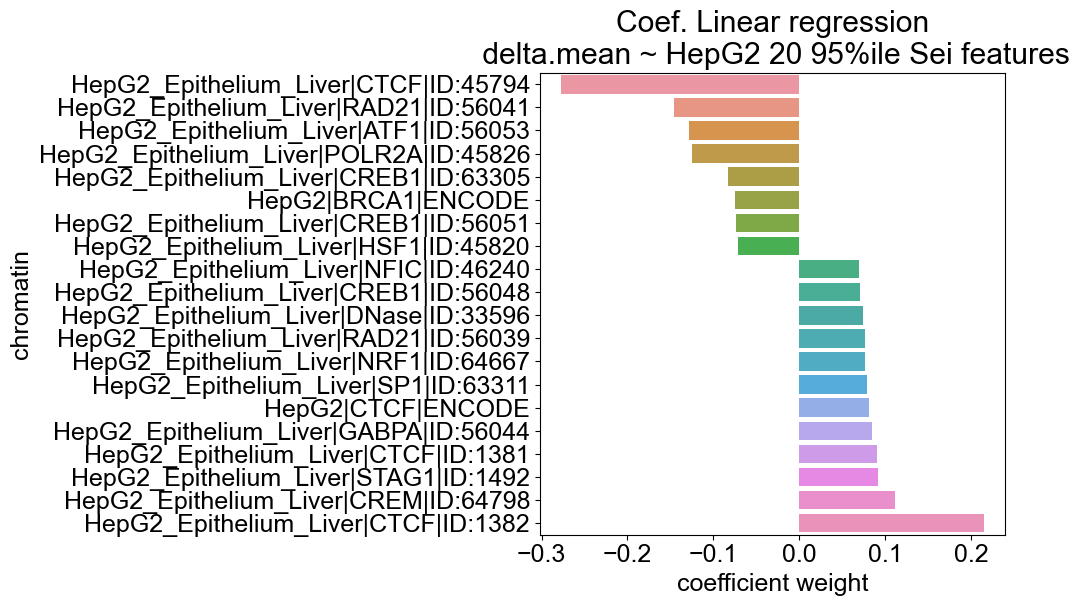

In [51]:
for y_col in y_cols:
    print("predicting", y_col)
    # set up X and Y
    group_col = "#chr"
    train_size = 0.8
    data = merged
    feature_matrix = merged
    sei_cols = list(feature_matrix)[6:-2]
    
    X = np.array(data[sei_cols])
    y = np.array(data[y_col])
    groups = np.array(data[group_col])
    
    # train test split
    trainX, trainy, testX, testy, traini, testi = train_test_split_Group(X, y, groups, train_size)
    
    # fit
    pipe.fit(trainX, trainy)

    # predict
    pred_y = pipe.predict(testX)

    ## r2, rho

    rsquared = pipe.score(testX, testy)
    rho, p = spearmanr(testy, pred_y)
    print('performance r2',  rsquared, "rho", rho)

    ## mean squared error , mean abs error (robust)

    rmse = mean_squared_error(testy, pred_y)
    mae = mean_absolute_error(testy, pred_y)
    print("error rmse", rmse, 'mae', mae)

    # PLOT
    #fig, ax= plt.subplots(figsize=(6,6))
    j = sns.jointplot(x=testy, y=pred_y, alpha=0.7)
    j.set_axis_labels('obs', 'pred')

    j.fig.suptitle(f"Linear regression\n {y_col} activity dif ~ 388 {QUERY} Sei chromatin features")

    j.fig.text(0.65,0.1, f"R2={round(rsquared, 2)}\nRMSE={round(rmse, 2)}")
    j.fig.text(0.65,0.2, f"rho={round(rho, 2)}\nMAE={round(mae, 2)}")

    OUT = os.path.join(RE, f"reg.mpra.{y_col}.obs.exp.pdf")
    plt.savefig(OUT, bbox_inches="tight")

    ## coeff weights

    reg = pipe.named_steps["reg"]

    coeff = {}
    for score, col in zip(reg.coef_, sei_cols):
        coeff[col]=score

    cscores = pd.DataFrame(coeff.items())

    cscores.columns=["chromatin", "score"]
    cscores.sort_values(by="score")

    fig, ax= plt.subplots(figsize=(6,6))
    data = cscores.loc[cscores["score"].abs() >cscores["score"].abs().quantile(0.95)]
    x="score" 
    y="chromatin"
    sns.barplot(x=x, y=y, data=data.sort_values(by="score"))
    ax.set(title = f"Coef. Linear regression\n {y_col} ~ {QUERY} {data.shape[0]} 95%ile Sei features",
           xlabel = "coefficient weight"
          )
    OUT = os.path.join(RE, f"reg.chromatin.{y_col}.coef.pdf")

    plt.savefig(OUT, bbox_inches="tight")


# regularization 
- lasso - doesn't work
- ridge, gridsearchcv recommends alpha=100

In [52]:
ytrain_df= np.array(merged.iloc[traini][y_col])
xtrain_df= np.array(merged.iloc[traini][sei_cols])
groups = np.array(merged.iloc[traini][group_col])

#gridSearchModel(xtrain_df, ytrain_df, True, groups)  # gridsearch does not do stratified group split. 

In [59]:
def cv(x_, y_, groups, model_name):
    
    best_score, best_rho = 0, 0
    
    
    last_test = set()
    # shuffle split on 
    gss = GroupShuffleSplit(n_splits=10, train_size=0.9, 
                            #random_state=42
                           )
    sc = StandardScaler()
    for alpha in [0.01, 0.1,10,100, 1000]:
        print("\ntesting alpha", alpha, "\n")
        mean_score, mean_rho = [],[]
        n = 0
        for train_index, test_index in gss.split(x_, y_, groups):
        
            print("fold", n)
            n+=1
            trainx_, testx_ = x_[train_index], x_[test_index]
            trainy_, testy_ = y_[train_index], y_[test_index]

            #print(len(set(test_index).difference(last_test)))

            # update last_test
            last_test = test_index        
            
            if model_name == "Ridge":
                model = Ridge(alpha=alpha)
                
            elif model_name == "Lasso":
                model = Lasso(alpha=alpha)
            
            elif model_name =="elastic":
                model = ElasticNet(alpha=alpha)
                
            elif model_name =="linear":
                model = LinearRegression()

            # scale features
            trainx_sc, testx_sc = sc.fit_transform(trainx_), sc.fit_transform(testx_)
            
            model.fit(trainx_sc, trainy_)
            
            y_pred = model.predict(testx_sc)
            
            score = model.score(testx_sc, testy_)
            
            rho, p = spearmanr(testy_, y_pred)
            
            # pearson
            if score > best_score:
                best_score = score
            
            # rho
            if rho> best_rho:
                best_rho = rho
            
            mean_score.append(score), mean_rho.append(rho)
        print(model_name,alpha, 
              "mean score", np.mean(mean_score).round(2), 
              #"best pearson", round(best_score,2),
              "mean rho", np.mean(mean_rho).round(2), 
              #"best rho", round(best_rho,2), 
              )
        if model_name =="linear":
            # no alpha optimization
            break

In [60]:
 cv(xtrain_df, ytrain_df, groups, "linear")


testing alpha 0.01 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
LinearRegression() 0.01 mean score -0.04 mean rho 0.08


In [54]:
 cv(xtrain_df, ytrain_df, groups, "Ridge")


testing alpha 0.01 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
Ridge(alpha=0.01) 0.01 mean score -0.04 mean rho 0.07

testing alpha 0.1 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
Ridge(alpha=0.1) 0.1 mean score -0.04 mean rho 0.07

testing alpha 10 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
Ridge(alpha=10) 10 mean score -0.03 mean rho 0.09

testing alpha 100 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
Ridge(alpha=100) 100 mean score -0.02 mean rho 0.08

testing alpha 1000 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
Ridge(alpha=1000) 1000 mean score 0.0 mean rho 0.1


In [40]:
 cv(xtrain_df, ytrain_df, groups, "elastic")


testing alpha 0 



/scratch/fongsl/ipykernel_23162/2795988854.py:34: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(trainx_, trainy_)
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e+03, tolerance: 4.488e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  mod

best rho 0.06571625007558578 0


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.059e+03, tolerance: 4.384e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_23162/2795988854.py:34: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

best rho 0.09797983314131636 0


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.917e+03, tolerance: 4.078e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_23162/2795988854.py:34: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

ElasticNet(alpha=0) mean score 0.0 mean rho 0.06895824224311733 0

testing alpha 10 



/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

ElasticNet(alpha=10) mean score 0.0 mean rho nan 10

testing alpha 100 



/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

ElasticNet(alpha=100) mean score 0.0 mean rho nan 100

testing alpha 1000 



/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

ElasticNet(alpha=1000) mean score 0.0 mean rho nan 1000


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [36]:
 cv(xtrain_df, ytrain_df, groups, "Lasso")


testing alpha 0 

3860


/scratch/fongsl/ipykernel_23162/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model = Lasso(alpha=alpha).fit(trainx_, trainy_)
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.135e+03, tolerance: 4.523e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/R

best rho 0.07309157628401787 0
3647


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.979e+03, tolerance: 4.192e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_23162/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

best rho 0.0998420263061004 0
1391


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.072e+03, tolerance: 4.386e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_23162/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

2809


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.125e+03, tolerance: 4.522e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_23162/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

3223


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.107e+03, tolerance: 4.463e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_23162/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

1683


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.090e+03, tolerance: 4.422e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_23162/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

2934


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.044e+03, tolerance: 4.345e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_23162/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

2916


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.141e+03, tolerance: 4.543e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_23162/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

4453


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e+03, tolerance: 4.081e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_23162/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

3187


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e+03, tolerance: 4.173e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0) mean score 0.0 mean rho 0.07496346444947555 0

testing alpha 10 

3116


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2729


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


730


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4370


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1141


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2901


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3037


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4684


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4146


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2781


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Lasso(alpha=10) mean score 0.0 mean rho nan 10

testing alpha 100 

3537


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1855


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3279


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4531


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2373


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4295


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1068


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3000


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2903


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2928


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Lasso(alpha=100) mean score 0.0 mean rho nan 100

testing alpha 1000 

2982


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2064


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3866


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3007


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4367


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2516


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2640


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4276


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2520


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2238
Lasso(alpha=1000) mean score 0.0 mean rho nan 1000


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


# gradient boosting

In [61]:
from sklearn import datasets, ensemble

In [62]:
params = {
    "n_estimators": 50,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [ ]:
regboost = ensemble.GradientBoostingRegressor(**params)
regboost.fit(trainX, trainy)

mseboost = mean_squared_error(testy, reg.predict(testX))
print("The mean squared error (MSE) on test set: {:.4f}".format(mseboost))


# other thoughts 


- regression: train on balanced dataset, but validate/test in unbalanced dataset. 
    - other models: SVM-regression, xgboost regression
    
    
- classification: significantly US-sensitive?


- bin activity score + multiclass classification: predict the bin? 


- gkm-SVM - gapped-kmer SVM with kmer features. 